Postprocessing bottom line

In [87]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt


Import video

In [88]:
video_number = "8"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Number of frames in the video: {frame_count}")


Number of frames in the video: 119


Get data (horizontal_lines)

In [89]:
# Define the path to the CSV file
input_data_path = project_root / "notebook"/ "lane_detection" / "intermediate_data" / f"horizontal_lines_{video_number}_raw.csv"

# Load the CSV file into a DataFrame
horizontal_lines = pd.read_csv(input_data_path)

print(horizontal_lines.head())

     rho     theta
0  980.0  1.570796
1  980.0  1.570796
2  980.0  1.570796
3  980.0  1.570796
4  980.0  1.570796


Get video movement

In [90]:
''' Import data of the movement from Camera_Motion_Test.ipynb '''
avg_movement_list = [0.57, 3.86, 5.18, 0.10, 0.16, 3.26, 0.52, 0.96]
avg_movement = avg_movement_list[int(video_number) - 1]
print(f"Average movement video {int(video_number)}: {avg_movement}")

Average movement video 8: 0.96


Funzioni

Disegna la linea sul frame

In [91]:
'''Disegna la linea sul singolo frame'''
def write_line_on_frame(frame, line):
    # Create a copy of the original frame to draw the first line
    modified_frame = np.copy(frame)

    # Extract the first line's rho and theta
    if line:
        rho, theta = line
        # Calculate the endpoints of the line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # Draw the first line on the frame
        cv2.line(modified_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # return the modified frame
    return modified_frame

Plotta la traiettoria dei punti 

In [92]:
def plot_trajectory(df):
    plt.figure(figsize=(8,6))
    plt.plot(df['X'], -df['Y'], 'o-', label='Cleaned Trajectory')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cleaned Trajectory')
    plt.legend()
    plt.show()

In [93]:
def plot_coordinates(df, title="Coordinates Plot", xlabel="X", ylabel="Y", save_path=None):
    # compute the mean and std of the X and Y coordinates
    mean_x = df['X'].mean()
    std_x = df['X'].std()
    mean_y = df['Y'].mean()
    std_y = df['Y'].std()
    # plot the values of x and y with the mean and std
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df['X'], label='X')
    plt.axhline(mean_x, color='r', linestyle='--', label='Mean')
    plt.axhline(mean_x + std_x, color='g', linestyle='--', label='Mean + Std')
    plt.axhline(mean_x - std_x, color='g', linestyle='--', label='Mean - Std')
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('X')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(df['Y'], label='Y')
    plt.axhline(mean_y, color='r', linestyle='--', label='Mean')
    plt.axhline(mean_y + std_y, color='g', linestyle='--', label='Mean + Std')
    plt.axhline(mean_y - std_y, color='g', linestyle='--', label='Mean - Std')
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Rimuove gli outliers

In [94]:
def remove_outliers(df, threshold=1):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
    
    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()
    distances = np.sqrt(dx**2 + dy**2)
    # Define outlier threshold
    median_dist = distances.mean()
    std_dist = distances.std()
    print(df)
    print('Median distance:', median_dist)
    print('Standard deviation of distances:', std_dist)
    outlier_threshold =  threshold * std_dist * 2

    mask = []
    
    for i in range(0, len(distances)-1):

        # Remove points that are  (0, 0)  (the ones that I set when it doesn't detect any line)
        if df['X'].iloc[i] == 0 and df['Y'].iloc[i] == 0:
            mask.append(i)
            prev_index = i - 1
            while prev_index in mask and prev_index >= 0:
                prev_index -= 1
            if prev_index < 0:
                print("No valid previous index found. Breaking.")
                break
            distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
            continue
        if distances[i] > outlier_threshold:
            # Create a mask to identify the outlier point
            mask.append(i)
            # convert the next point distance in the distance with respect to the previous point
            if i < len(distances) - 1 and i > 0:
                # select the previous point as the last point evaluated non present in the mask
                prev_index = i - 1
                while prev_index in mask and prev_index >= 0:
                    prev_index -= 1
                if prev_index < 0:
                    print("No valid previous index found. Breaking.")
                    break
                distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
                # print('New distance:', distances[i+1], 'for point:', i+1, 'with respect to point:', prev_index)
   # Remove the outlier points from the DataFrame
    df = df.drop(mask)
    print('Outliers removed:', len(mask))

    # compute means and standard deviations of points
    mean_x = df['X'].mean()
    mean_y = df['Y'].mean()
    std_x = df['X'].std()
    std_y = df['Y'].std()   

    threshold_std = 1

    # Remove points too far from the mean
    df = df[(df['X'] > mean_x - threshold_std*std_x) & (df['X'] < mean_x + threshold_std*std_x) & (df['Y'] > mean_y - threshold_std*std_y) & (df['Y'] < mean_y + threshold_std*std_y)]
    
    return df

In [95]:
def remove_outliers_iterated(df, threshold_factor=1): 
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')

    first_iteration = True
    exit_threshold = 10000
    max_dist = np.inf

    # remove the points that are 0,0
    df = df[(df['X'] != 0) | (df['Y'] != 0)]

    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()

    # compute distances
    df['distance'] = np.sqrt(dx**2 + dy**2)
    
    while max_dist > exit_threshold:
        # set the threshold to exit the while
        if first_iteration:
            first_iteration = False
            mean_dist = np.mean(df['distance'])
            std = np.std(df['distance'])
            print('media:', mean_dist, 'std:', std)
            if std > mean_dist:
                exit_threshold = std
            else:
                exit_threshold = 2 * mean_dist

        # set the threshold for outliers removal
        if threshold_factor > 1:
            threshold_dist = threshold_factor * np.mean(df['distance'])
        else:   
            threshold_dist = 1 * np.mean(df['distance'])
            
        # outliers removal
        df = df[(df['distance'] < threshold_dist) & df['distance'].notna()]  # the first value is considered as correct

        # Compute the distance between consecutive points
        dx = df['X'].diff()
        dy = df['Y'].diff()

        # compute distances
        df['distance'] = np.sqrt(dx**2 + dy**2)

        # get the max distance
        max_dist = np.max(df['distance'])

    return df

In [96]:
def remove_outliers_xy(df):
    # compute the mean and std of the X and Y coordinates
    mean_x = df['X'].mean()
    std_x = df['X'].std()
    mean_y = df['Y'].mean()
    std_y = df['Y'].std()

    # set the threshold
    threshold_x =  std_x * 2
    threshold_y =  std_y * 2
    # remove outliers: remove the points that have a distance on each axis with respect to the previous point greater than the threshold
    mask = []
    for i in range(len(df.index.values)):
        if df['X'].iloc[i] == 0 and df['Y'].iloc[i] == 0:
            mask.append(df.index.values[i])
            continue
        # compute the first feasible previous index
        prev_index = i - 1
        while df.index.values[prev_index] in mask and prev_index >= 0:
            prev_index -= 1
        if (abs(df['X'].iloc[i] - df['X'].iloc[prev_index]) > threshold_x or abs(df['Y'].iloc[i] - df['Y'].iloc[prev_index]) > threshold_y) and prev_index >= 0:
            mask.append(df.index.values[i])
    
    # Remove the outlier points from the DataFrame
    df = df.drop(mask)

    return df

filtro a media mobile

In [97]:
def median_filter(df, kernel_size=3):
    """
    Smooths the X and Y coordinates using a median filter to reduce noise.
    """
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df['X'] = medfilt(df['X'], kernel_size=kernel_size)
    df['Y'] = medfilt(df['Y'], kernel_size=kernel_size)
    
    return df

Smoothing

In [98]:
def Savitzky_Golay_filter(df, window_length=5, polyorder=1):
    """
    Smooths the X and Y coordinates using Savitzky-Golay filter to reduce noise.
    """
    df['X'] = savgol_filter(df['X'], window_length=window_length, polyorder=polyorder)
    df['Y'] = savgol_filter(df['Y'], window_length=window_length, polyorder=polyorder)
    
    # # Round the smoothed coordinates to integers
    # df['X'] = df['X'].round().astype(int)
    # df['Y'] = df['Y'].round().astype(int)
    
    return df

Interpola i punti per ricavere quelli mancanti (eliminati precedentemente perchè errati)

In [99]:
def interpolate_missing_coordinates(df, end_frame, start_frame=0): 
    """
    Interpolate the missing coordinates between the frames from start_frame to end_frame.
    Ensures a smooth trajectory by interpolating both X and Y coordinates.
    """
    # Create a DataFrame with all frames from start_frame to end_frame
    all_frames = pd.DataFrame({'Frame': range(start_frame, end_frame + 1)})
    
    # Merge with the original dataframe
    df_full = pd.merge(all_frames, df, on='Frame', how='left')
    
    # Interpolate the missing 'X' and 'Y' coordinates (linear interpolation)
    df_full['X'] = df_full['X'].interpolate(method='linear')
    df_full['Y'] = df_full['Y'].interpolate(method='linear')

    # Fill any remaining NaN values using forward and backward filling
    df_full['X'] = df_full['X'].bfill().ffill()
    df_full['Y'] = df_full['Y'].bfill().ffill()
    
    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)
    
    return df_full

Calcola il punto di intersezione di ogni linea con la linea ortogonale che passa per l'origine

In [100]:
def get_intersections(horizontal_lines):
    # Calcola il punto  per ogni linea
    intersection_points = []

    for rho, theta in zip(horizontal_lines['rho'], horizontal_lines['theta']):
        # Calcola i coefficienti della linea
        x = np.cos(theta) * rho
        y = np.sin(theta) * rho

        # Aggiungi il punto  alla lista
        intersection_points.append((x, y))
        
    return intersection_points

In [101]:
def get_intersection_cartesian(horizontal_lines):
    intersection_points = []

    for x1, y1, x2, y2 in horizontal_lines[['x1', 'y1', 'x2', 'y2']].values:
        # Calculate the line coefficients (a, b, c) for ax + by + c = 0
        a = y2 - y1
        b = x1 - x2
        c = x2 * y1 - x1 * y2

        # Calculate the intersection with the orthogonal line passing through the origin
        # The orthogonal line has equation bx - ay = 0
        denominator = a**2 + b**2
        if denominator == 0:
            intersection_points.append((0, 0))
            continue  # Skip degenerate lines

        x = -a * c / denominator
        y = -b * c / denominator

        # Append the intersection point
        intersection_points.append((x, y))

    return intersection_points

Recompute the lines from the points

In [102]:
def lines_from_point(points_interpolated):    
# Riconversione dei punti in linee (rho e theta)
    reconverted_lines = []

    for x, y in points_interpolated[['X', 'Y']].values:
        rho = np.sqrt(x**2 + y**2)  # Distanza dall'origine
        theta = np.arctan2(y, x)    # Angolo rispetto all'asse x
        reconverted_lines.append((rho, theta))
    return reconverted_lines

In [103]:
def lines_from_point_cartesian(points_interpolated, length=1000):    
# Generate lines (as two points) orthogonal to the origin-point vector, passing through the point
    reconverted_lines = []

    for x, y in points_interpolated[['X', 'Y']].values:
        # Orthogonal direction to vector (x, y)
        dx = -y
        dy = x

        # Normalize direction vector
        norm = (dx**2 + dy**2)**0.5
        dx /= norm
        dy /= norm

        # Generate two points along the orthogonal line centered at (x, y)
        x1 = x + dx * length / 2
        y1 = y + dy * length / 2
        x2 = x - dx * length / 2
        y2 = y - dy * length / 2

        reconverted_lines.append(((x1, y1), (x2, y2)))

    return reconverted_lines

Main

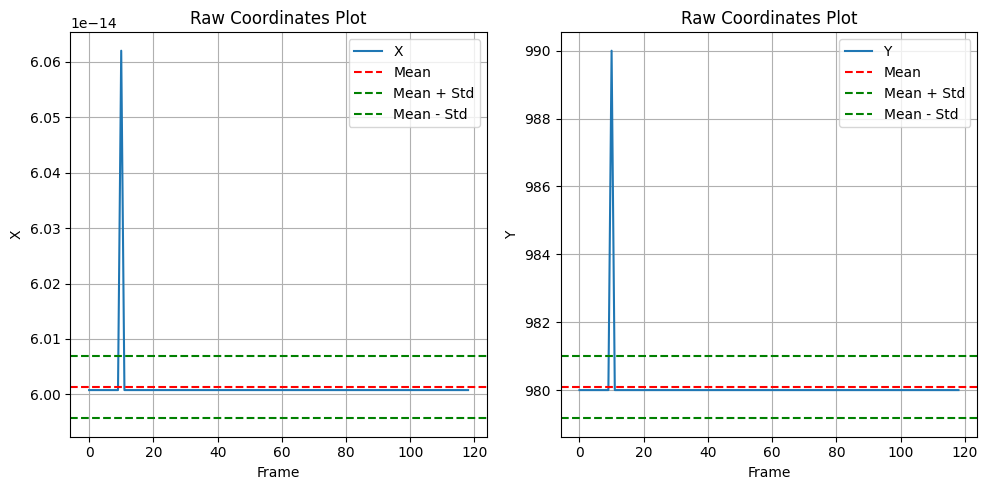

     Frame             X      Y
0        0  6.000769e-14  980.0
1        1  6.000769e-14  980.0
2        2  6.000769e-14  980.0
3        3  6.000769e-14  980.0
4        4  6.000769e-14  980.0
..     ...           ...    ...
114    114  6.000769e-14  980.0
115    115  6.000769e-14  980.0
116    116  6.000769e-14  980.0
117    117  6.000769e-14  980.0
118    118  6.000769e-14  980.0

[119 rows x 3 columns]
Median distance: 0.1694915254237288
Standard deviation of distances: 1.2963135419615373
Outliers removed: 1


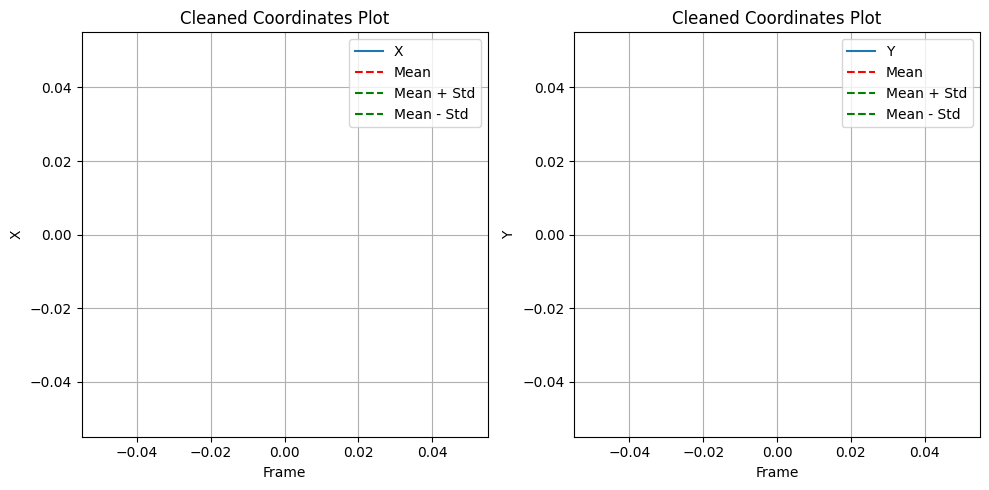

In [104]:
# get the intersection points
intersection_points = get_intersections(horizontal_lines)
# remove outliers
# Create a DataFrame from intersection_points
points_df = pd.DataFrame(intersection_points, columns=['X', 'Y'])
points_df['Frame'] = range(len(points_df))
# plot_trajectory(points_df)
plot_coordinates(points_df, title="Raw Coordinates Plot")

# Reorder columns to have 'Frame', 'X', 'Y' 
points_df = points_df[['Frame', 'X', 'Y']]

# Remove outliers
points_cleaned = remove_outliers(points_df)

# plot_trajectory(points_cleaned)
plot_coordinates(points_cleaned, title="Cleaned Coordinates Plot")

if avg_movement > 1:
    # Smooth the trajectory to reduce noise
    points_smoothed = median_filter(points_cleaned)
    # plot_trajectory(points_smoothed)
    plot_coordinates(points_smoothed, title="Smoothed Coordinates Plot")

    # Interpolate missing coordinates
    points_interpolated = interpolate_missing_coordinates(points_smoothed, len(points_df)-1)
    plot_coordinates(points_interpolated, title="Interpolated Coordinates Plot")
    #plot
    # plot_trajectory(points_interpolated)
    # print("len(points_interpolated):", len(points_interpolated))
    # print('mean:', points_interpolated['X'].mean(), points_interpolated['Y'].mean())

    reconverted_lines = lines_from_point(points_interpolated)
else:
    #get the mean point because I'm assuming the video still
    mean_point = points_cleaned.mean()
    # print('mean point:', mean_point)

    #create a list of length of the original df where each element is mean_point
    mean_point_list = [mean_point] * len(intersection_points)
    mean_point_df = pd.DataFrame(mean_point_list, columns=['X', 'Y'])

    reconverted_lines = lines_from_point(mean_point_df)

Generate video

In [105]:
# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Define the codec and create a VideoWriter object to save the modified frames
output_path = project_root / "data" / f"recording_{video_number}" / "Adjusted_Bottom_line_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# Loop through each frame in the video
frame_index = 0
while frame_index < len(reconverted_lines):
    ret, video_frame = cap.read()
    if not ret:
        print("End of video or failed to read the frame at iteration", frame_index)
        break
    modified_frame = write_line_on_frame(video_frame, reconverted_lines[frame_index])

    # Write the modified frame to the output video
    out.write(modified_frame)

    # Increment the frame index
    frame_index += 1

# Release the video capture and writer objects
# cap.release()

out.release()

print(f"Adjusted video saved to {output_path}")

ValueError: cannot convert float NaN to integer

In [ ]:
# Convert reconverted_lines to a DataFrame
reconverted_lines_df = pd.DataFrame(reconverted_lines, columns=['rho', 'theta'])

# Define the path to save the reconverted lines
output_path_lines = project_root / "notebook" / "lane_detection" / "intermediate_data" / "lane_lines" / f"horizontal_lines_{video_number}.csv"

# Save the DataFrame to a CSV file
reconverted_lines_df.to_csv(output_path_lines, index=False)

print(f"Reconverted lines saved to {output_path_lines}")

Reconverted lines saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\notebook\lane_detection\intermediate_data\lane_lines\horizontal_lines_5.csv


In [ ]:
cap.release()